In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pycountry
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import zipfile
import math

In [2]:
# Importing data
main_df = pd.read_excel("Data/organizedviolencecy_v23_2.xlsx")

# List of country codes to keep (recognized country)
recognized_country_codes = [
    "AFG", "ALA", "ALB", "DZA", "ASM", "AND", "AGO", "AIA", "ATA", "ATG", "ARG", "ARM", "ABW", "AUS", "AUT", "AZE",
    "BHS", "BHR", "BGD", "BRB", "BLR", "BEL", "BLZ", "BEN", "BMU", "BTN", "BOL", "BES", "BIH", "BWA", "BVT", "BRA",
    "IOT", "BRN", "BGR", "BFA", "BDI", "CPV", "KHM", "CMR", "CAN", "CYM", "CAF", "TCD", "CHL", "CHN", "CXR", "CCK",
    "COL", "COM", "COG", "COD", "COK", "CRI", "CIV", "HRV", "CUB", "CUW", "CYP", "CZE", "DNK", "DJI", "DMA", "DOM",
    "ECU", "EGY", "SLV", "GNQ", "ERI", "EST", "SWZ", "ETH", "FLK", "FRO", "FJI", "FIN", "FRA", "GUF", "PYF", "ATF",
    "GAB", "GMB", "GEO", "DEU", "GHA", "GIB", "GRC", "GRL", "GRD", "GLP", "GUM", "GTM", "GGY", "GIN", "GNB", "GUY",
    "HTI", "HMD", "VAT", "HND", "HKG", "HUN", "ISL", "IND", "IDN", "IRN", "IRQ", "IRL", "IMN", "ISR", "ITA", "JAM",
    "JPN", "JEY", "JOR", "KAZ", "KEN", "KIR", "PRK", "KOR", "KWT", "KGZ", "LAO", "LVA", "LBN", "LSO", "LBR", "LBY",
    "LIE", "LTU", "LUX", "MAC", "MDG", "MWI", "MYS", "MDV", "MLI", "MLT", "MHL", "MTQ", "MRT", "MUS", "MYT", "MEX",
    "FSM", "MDA", "MCO", "MNG", "MNE", "MSR", "MAR", "MOZ", "MMR", "NAM", "NRU", "NPL", "NLD", "NCL", "NZL", "NIC",
    "NER", "NGA", "NIU", "NFK", "MKD", "MNP", "NOR", "OMN", "PAK", "PLW", "PSE", "PAN", "PNG", "PRY", "PER", "PHL",
    "PCN", "POL", "PRT", "PRI", "QAT", "REU", "ROU", "RUS", "RWA", "BLM", "SHN", "KNA", "LCA", "MAF", "SPM", "VCT",
    "WSM", "SMR", "STP", "SAU", "SEN", "SRB", "SYC", "SLE", "SGP", "SXM", "SVK", "SVN", "SLB", "SOM", "ZAF", "SGS",
    "SSD", "ESP", "LKA", "SDN", "SUR", "SJM", "SWE", "CHE", "SYR", "TWN", "TJK", "TZA", "THA", "TLS", "TGO", "TKL",
    "TON", "TTO", "TUN", "TUR", "TKM", "TCA", "TUV", "UGA", "UKR", "ARE", "GBR", "USA", "UMI", "URY", "UZB", "VUT",
    "VEN", "VNM", "VGB", "VIR", "WLF", "ESH", "YEM", "ZMB", "ZWE"
]


In [3]:


# Create dictionaries to map country names to ISO codes and vice versa
country_name_to_iso = {country.name: country.alpha_3 for country in pycountry.countries}
iso_to_country_name = {country.alpha_3: country.name for country in pycountry.countries}

# Create DataFrames from the dictionaries
df_country_name_to_iso = pd.DataFrame(list(country_name_to_iso.items()), columns=['Country Name', 'ISO_Code'])
df_iso_to_country_name = pd.DataFrame(list(iso_to_country_name.items()), columns=['ISO_Code', 'Country Name'])

# Merge the DataFrames into a single DataFrame without duplicating "Country Name"
iso_df = pd.merge(df_country_name_to_iso, df_iso_to_country_name, on='ISO_Code', how='inner', suffixes=('_country', '_iso'))

# Rename the "Country Name" column to "Name"
iso_df.rename(columns={'Country Name_country': 'Name', 'ISO_Code': 'stateid'}, inplace=True)

# Drop the duplicate "Country Name_iso" column
iso_df.drop(columns=['Country Name_iso'], inplace=True)

# Only keep the countries in the recognized_country_codes list
iso_df = iso_df[iso_df['stateid'].isin(recognized_country_codes)]



In [4]:
# Cleaning of GDP dataset: GDP between 1989 and 2022 in current US dollars
gdp_df = pd.read_csv("Data/gdp_world.csv", skiprows=4)



# Only keep relevant columns
gdp_df = gdp_df[["Country Name", "Country Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997",
                 "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010",
                 "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"]]

# Only keep the countries recognized in the recognized_country_codes list
gdp_df = gdp_df[gdp_df["Country Code"].isin(recognized_country_codes)]

# Backfill NaN values
gdp_df = gdp_df.fillna(method='bfill', axis=1)

# rename Country Code to stateid
gdp_df = gdp_df.rename(columns={"Country Code": "stateid"})

# Frontfill NaN values -> some countries miss their 2022 value
gdp_df = gdp_df.fillna(method='ffill', axis=1)

# Replace country name next to stateid = COD to "DR Congo (Zaire)"
gdp_df.loc[gdp_df['stateid'] == 'COD', 'Country Name'] = "DR Congo (Zaire)"

# Initialize the mapping dictionary
name_mapping = {
    "Congo, Dem. Rep.": "Congo",
    "Tanzania": "Tanzania, United Republic of",
    "Turkiye": "Türkiye",
    "Moldova": "Moldova, Republic of",
    "Bahamas, The": "Bahamas",
    "Macao SAR, China": "China",
    "Korea, Rep.": "Korea, Republic of",
    "Curacao": "Curaçao",
    "Egypt, Arab Rep.": "Egypt",
    "Congo, Rep.": "Congo",
    "Bolivia": "Bolivia, Plurinational State of",
    "Virgin Islands (U.S.)": "Virgin Islands, U.S.",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Martin (French part)": "Saint Martin (French part)",
    "Hong Kong SAR, China": "Hong Kong",
    "British Virgin Islands": "Virgin Islands, British",
    "Yemen, Rep.": "Yemen",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "Gambia, The": "Gambia",
}

# Manually update the mapping dictionary with the correct ISO names
name_mapping["Micronesia, Fed. Sts."] = "Micronesia, Federated States of"
name_mapping["Lao PDR"] = "Laos"
name_mapping["Iran, Islamic Rep."] = "Iran, Islamic Republic of"
name_mapping["Korea, Dem. People's Rep."] = "Korea, Democratic People's Republic of"
name_mapping["Kyrgyz Republic"] = "Kyrgyzstan"
name_mapping["St. Lucia"] = "Saint Lucia"
name_mapping["Slovak Republic"] = "Slovakia"

# Apply name mapping to GDP dataset
gdp_df['Country Name'] = gdp_df['Country Name'].map(name_mapping).fillna(gdp_df['Country Name'])

gdp_countries = gdp_df['Country Name'].unique()
iso_countries = iso_df['Name'].unique()

# Check if the same stateid is used for each country in both datasets
consistent_stateids = True
inconsistent_countries = []

for country in gdp_countries:
    if country in iso_countries:
        gdp_stateid = gdp_df.loc[gdp_df['Country Name'] == country, 'stateid'].iloc[0]
        iso_stateid = iso_df.loc[iso_df['Name'] == country, 'stateid'].iloc[0]
        
        if gdp_stateid != iso_stateid:
            consistent_stateids = False
            inconsistent_countries.append(country)

if consistent_stateids:
    print("The same stateid is used for each country in both datasets.")
else:
    print("The stateids are not consistent for the following countries:")
    print(inconsistent_countries)

# No data available for North Korea; estimation from tradingeconomics.com + linear interpolation

nk_gdp = {
    1989: 15770000000,
    1990: None,
    1991: None,
    1992: 11000000000,
    1993: None,
    1994: None,
    1995: 4850000000,
    1996: None,
    1997: None,
    1998: 11000000000,
    1999: None,
    2000: None,
    2001: None,
    2002: None,
    2003: None,
    2004: None,
    2005: None,
    2006: None,
    2007: None,
    2008: None,
    2009: None,
    2010: None,
    2011: None,
    2012: None,
    2013: None,
    2014: None,
    2015: None,
    2016: None,
    2017: None,
    2018: None,
    2019: None,
    2020: None,
    2021: None,
    2022: 20000000000
}

# Convert the dictionary to a DataFrame
nk_gdp_df = pd.DataFrame.from_dict(nk_gdp, orient='index', columns=['GDP'])

# Convert index to a column
nk_gdp_df.reset_index(inplace=True)
nk_gdp_df.rename(columns={'index': 'Year'}, inplace=True)

# Interpolate missing values linearly
nk_gdp_df['GDP'] = nk_gdp_df['GDP'].interpolate()

# Provided data
nk_gdp_values = {
    1989: 1.577000e+10, 1990: 1.418000e+10, 1991: 1.259000e+10, 1992: 1.100000e+10, 1993: 8.950000e+09,
    1994: 6.900000e+09, 1995: 4.850000e+09, 1996: 6.900000e+09, 1997: 8.950000e+09, 1998: 1.100000e+10,
    1999: 1.137500e+10, 2000: 1.175000e+10, 2001: 1.212500e+10, 2002: 1.250000e+10, 2003: 1.287500e+10,
    2004: 1.325000e+10, 2005: 1.362500e+10, 2006: 1.400000e+10, 2007: 1.437500e+10, 2008: 1.475000e+10,
    2009: 1.512500e+10, 2010: 1.550000e+10, 2011: 1.587500e+10, 2012: 1.625000e+10, 2013: 1.662500e+10,
    2014: 1.700000e+10, 2015: 1.737500e+10, 2016: 1.775000e+10, 2017: 1.812500e+10, 2018: 1.850000e+10,
    2019: 1.887500e+10, 2020: 1.925000e+10, 2021: 1.962500e+10, 2022: 2.000000e+10
}

# Locate the row with stateid equal to "PRK" in gdp_df
prk_row_index = gdp_df.index[gdp_df['stateid'] == 'PRK'].tolist()[0]

# Replace the values in columns 1989 to 2022 with the provided values
for year, gdp_value in nk_gdp_values.items():
    gdp_df.at[prk_row_index, str(year)] = gdp_value


# No data for Virgin Islands and Gibraltar: drop the columns (not used in main_df)
gdp_df = gdp_df[~gdp_df['stateid'].isin(['VGB', 'GIB'])]


The same stateid is used for each country in both datasets.


C:\Users\troen\AppData\Local\Temp\ipykernel_4352\4244091700.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='bfill', axis=1)
C:\Users\troen\AppData\Local\Temp\ipykernel_4352\4244091700.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='ffill', axis=1)


In [5]:
# Extracting from zip file
zip_file_path = "Data/EdStats_CSV.zip"

csv_file_name = 'EdStatsData.csv'

# Open the .zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file from the .zip archive
    with zip_ref.open(csv_file_name) as csv_file:
        # Read the CSV file using pandas
        education_df = pd.read_csv(csv_file)



# Only keep relevant columns, between 1989 and 2022
education_df = education_df[["Country Name", "Country Code", "Indicator Name" ,"Indicator Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995",
                             "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
                             "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]

# Delete rows where every year is NaN
education_df = education_df.dropna(how='all', subset=["1989", "1990", "1991", "1992", "1993", "1994", "1995",
                                                      "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003",
                                                      "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011",
                                                      "2012", "2013", "2014", "2015", "2016", "2017"])


# Drop all rows where indicator name = Population growth (annual %)
education_df = education_df[education_df["Indicator Name"] != "Population growth (annual %)"]


# Drop all columns where more than 35% of the values are NaN
education_df = education_df.dropna(thresh=0.35*len(education_df), axis=1)

# Drop 2003, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2015
education_df = education_df.drop(columns=["2003", "2006", "2007", "2008", "2009", "2011", "2012", "2013", "2015"])

# Drop rows where the value for 1995, 2000, 2005 and 2010 is NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], how='all')

# Drop the rows where 2 or more value for 1995, 2000, 2005 and 2010 are NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], thresh=2)

# Pivot the dataframe
education_df = education_df.pivot_table(index=['Country Name', 'Country Code'], columns='Indicator Name', values=['1995', '2000', '2005', '2010'])

# Reset index to make 'Country Name' and 'Country Code' regular columns
education_df.reset_index(inplace=True)

# Flatten column names
education_df.columns = [' '.join(col).strip() for col in education_df.columns.values]

# Drop columns where more than 50% of the values are NaN
education_df = education_df.dropna(thresh=0.5*len(education_df), axis=1)

# Drop all columns that contain the word "total"
education_df = education_df[education_df.columns.drop(list(education_df.filter(like='Total')))]


In [6]:
# Cleaning the main_df

# Remove columns with disagregated deaths. Only keep "prior" information and cumulative total deaths.
main_df = main_df.loc[:, ['country_id_cy', 'country_cy', 'year_cy', 'region_cy', 'sb_dyad_count_cy', 'sb_dyad_ids_cy',
                          'sb_intrastate_dyad_count_cy', 'sb_intrastate_main_govt_inv_incomp_cy',
                          'sb_interstate_dyad_count_cy',
                          'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'ns_dyad_ids_cy',
                          'os_dyad_count_cy', 'os_dyad_ids_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
                          'os_nsgroup_inv_cy', 'cumulative_total_deaths_parties_in_orgvio_cy',
                          'cumulative_total_deaths_civilians_in_orgvio_cy', 'cumulative_total_deaths_unknown_in_orgvio_cy',
                          'cumulative_total_deaths_in_orgvio_best_cy']]

# Importing battle_death data set, to get the dyads 

# importing battle_death dataset
battle_death_df = pd.read_csv("Data/battle_deaths.csv")


# Function to get incompatibility value from battle_death_df based on dyad_id
def get_incompatibility(dyad_ids):
    # Initialize a list to store incompatibility values for each dyad_id
    incompatibilities = []
    
    # Split the dyad_ids separated by ";"
    dyad_ids = dyad_ids.split(";")
    
    # Iterate over each dyad_id
    for dyad_id in dyad_ids:
        # Check if dyad_id is 'NO_DYAD'
        if dyad_id != 'NO_DYAD':
            # Look up the incompatibility value from battle_death_df
            incompatibility = battle_death_df.loc[battle_death_df['dyad_id'] == int(dyad_id), 'incompatibility'].values
            # If the dyad_id is found, append the incompatibility value to the list
            if len(incompatibility) > 0:
                incompatibilities.extend(incompatibility)
    
    # Return the maximum incompatibility value found for the dyad_ids
    return max(incompatibilities) if incompatibilities else None

# Create a new column 'incompatibility' in main_df using the function
main_df['incompatibility'] = main_df['sb_dyad_ids_cy'].apply(get_incompatibility)

main_df.insert(main_df.columns.get_loc('sb_dyad_ids_cy') + 1, 'incompatibility', main_df.pop('incompatibility'))

# Replace NaN values from 'incompatibility' column with 0 (= no state incompatibility)
main_df['incompatibility'] = main_df['incompatibility'].fillna(0)

# Change Incompatibility values to integers
main_df['incompatibility'] = main_df['incompatibility'].astype(int)

#####################################################
non_state = pd.read_csv("Data/Nonstate_v23_1.csv")

# Convert 'dyad_id' column in 'non_state' DataFrame to string type
non_state['dyad_id'] = non_state['dyad_id'].astype(str)

# Explode the 'ns_dyad_ids_cy' column to create multiple rows for each id
exploded_df = main_df.explode('ns_dyad_ids_cy')

# Merge with 'non_state' DataFrame on 'dyad_id'
prepcluster_df = exploded_df.merge(non_state, how='left', left_on='ns_dyad_ids_cy', right_on='dyad_id')

# Convert 'org' column to string type
prepcluster_df['org'] = prepcluster_df['org'].astype(str)

# Group by the original index and aggregate the 'org' values
grouped_df = prepcluster_df.groupby(prepcluster_df.index)['org'].apply(lambda x: ';'.join(x)).reset_index()

# Merge the aggregated 'org' values back to 'main_df'
main_df = main_df.merge(grouped_df, how='left', left_index=True, right_on='index')

# Drop unnecessary columns except 'ns_dyad_ids_cy'
main_df.drop(columns=['index'], inplace=True)

# Rename the merged column to 'org'
main_df.rename(columns={'org_x': 'org'}, inplace=True)

# Replace "nan" with 0 in 'org' column
main_df['org'] = main_df['org'].replace('nan', 0)

# Drop columns: sb_instrastate_dyad_count, sb_interstate_dyad_count
main_df = main_df.drop(columns=['sb_intrastate_dyad_count_cy', 'sb_interstate_dyad_count_cy'])


In [7]:
# adding acled data
# acled_df = pd.read_excel("Data/acled.xlsx")

In [8]:
main_df_countries = set(main_df['country_cy'].unique())
gdp_df_countries = set(gdp_df['Country Name'].unique())

# Find exact matches
exact_matches = main_df_countries.intersection(gdp_df_countries)

reverse_country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Congo, Democratic Republic of the': 'DR Congo (Zaire)',
    'Germany': 'German Democratic Republic',
    "Côte d'Ivoire": 'Ivory Coast',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Kosovo': 'Kosovo',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    "Korea, Democratic People's Republic of": 'North Korea',
    'Korea, Republic of': 'South Korea',
    'Russian Federation': 'Russia (Soviet Union)',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Syrian Arab Republic': 'Syria',
    'Tanzania, United Republic of': 'Tanzania',
    'Türkiye': 'Turkey',
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam (North Vietnam)',
    'Yemen': 'Yemen (North Yemen)',
    'Bolivia, Plurinational State of': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Czechia': 'Czech Republic',
    'Czech Republic': 'Czechoslovakia',
    'Timor-Leste': 'East Timor',
    'Micronesia, Federated States of': 'Federated States of Micronesia',
    'Iran, Islamic Republic of': 'Iran',
    'Moldova, Republic of': 'Moldova',
    'Taiwan, Province of China': 'Taiwan',
    'Vatican City': 'Vatican City State',
    'Venezuela, RB': 'Venezuela',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}

# Update the country names in gdp_df based on the reverse mapping
gdp_df['Country Name Mapped'] = gdp_df['Country Name'].map(lambda x: reverse_country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(gdp_df['Country Name Mapped'].unique()) - main_df_countries
#print("Remaining Non-Matches:")
#print(sorted(remaining_non_matches))

# Filter gdp_df to keep only the rows with matching country names in main_df
matching_country_names = set(main_df['country_cy'].unique())

In [10]:

# Fill any remaining NaN values in the original DataFrame
numeric_cols = education_df.select_dtypes(include=['float64', 'int64']).columns
education_df[numeric_cols] = education_df[numeric_cols].fillna(education_df[numeric_cols].median())

# Define a range of values for K
k_values = range(1, 21)  # Adjust the range as needed

# Initialize lists to store mean squared errors
mse_values = []

# Iterate over each value of K
for k in k_values:
    # Create KNN imputer object
    imputer = KNNImputer(n_neighbors=k)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(education_df[numeric_cols])
    
    # Convert the imputed array back to DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)
    
    # Compute mean squared error only for imputed values
    mse = mean_squared_error(education_df[numeric_cols], imputed_df)
    
    # Append MSE to the list
    mse_values.append(mse)


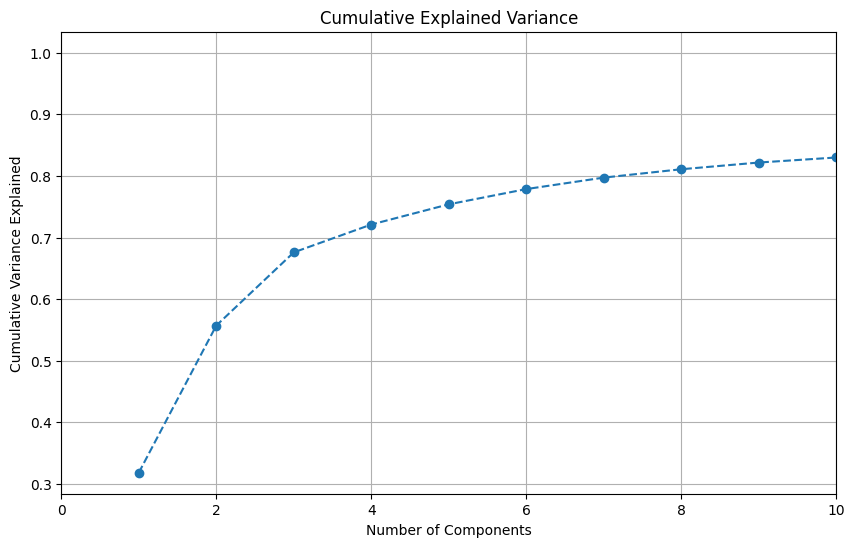

In [11]:
# Extract country names
countries = education_df['Country Name']

# Drop non-numeric columns (like country names and codes)
data_numeric = education_df.drop(['Country Name', 'Country Code'], axis=1)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 10)  # Limiting x-axis to values from 0 to 10
plt.grid(True)
plt.show()


# Perform PCA with 8 components
pca = PCA(n_components=8)
pca_data = pca.fit_transform(data_scaled)

# Create DataFrame for PCA results
pca_columns = [f"PC{i}" for i in range(1, 9)]  # PC1 to PC8 column names
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Add 'Country Name' to the PCA DataFrame
pca_df['Country Name'] = countries.reset_index(drop=True)  # Resetting index to ensure alignment

# Make the Country Name column the first column
pca_df = pca_df[['Country Name'] + pca_columns]

# Rename country name as pca_name
pca_df.rename(columns={'Country Name': 'pca_name'}, inplace=True)

# Pivoting the acled DataFrame
# acled_df = acled_df.pivot(index='Country', columns='Year', values='Events')

# only keep column from 2018 to 2023
# acled_df = acled_df.loc[:, 2018:2023]

In [12]:
country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Bahamas, The': 'Bahamas',
    "Cote d'Ivoire": "Ivory Coast",
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'DR Congo (Zaire)',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Iran, Islamic Rep.': 'Iran',
    'Micronesia, Fed. Sts.': 'Federated States of Micronesia',
    'Venezuela, RB': 'Venezuela',
    'Korea, Dem. People’s Rep.': 'North Korea',
    'Korea, Rep.': 'South Korea',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Yemen, Rep.': 'Yemen',
    'Macedonia, FYR': 'North Macedonia',
    'Timor-Leste': 'East Timor',
    'Russian Federation': 'Russia (Soviet Union)',
    'United States': 'United States of America',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    'Bolivia': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Comoros': 'Comoros',
    'Congo, Rep.': 'Congo',
    'Germany': 'Germany',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Saint Kitts and Nevis': 'Saint Kitts and Nevis',
    'Saint Lucia': 'Saint Lucia',
    'Saint Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Syria': 'Syrian Arab Republic',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': 'Korea, Republic of',
    'Turkey': 'Türkiye',
    'Vietnam': 'Vietnam (North Vietnam)',
    'Laos': 'Lao PDR',
    'Kosovo': 'Kosovo',
    'American Samoa': 'American Samoa',
    'Aruba': 'Aruba',
    'Bermuda': 'Bermuda',
    'British Virgin Islands': 'British Virgin Islands',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Cayman Islands': 'Cayman Islands',
    'Channel Islands': 'Channel Islands',
    'Curacao': 'Curacao',
    'Czechia': 'Czech Republic',
    'Faroe Islands': 'Faroe Islands',
    'French Polynesia': 'French Polynesia',
    'Gibraltar': 'Gibraltar',
    'Greenland': 'Greenland',
    'Guam': 'Guam',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Isle of Man': 'Isle of Man',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'New Caledonia': 'New Caledonia',
    'Northern Mariana Islands': 'Northern Mariana Islands',
    'Puerto Rico': 'Puerto Rico',
    'Sint Maarten (Dutch part)': 'Sint Maarten (Dutch part)',
    'Slovak Republic': 'Slovakia',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Martin (French part)': 'St. Martin (French part)',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Swaziland': 'Kingdom of eSwatini (Swaziland)',
    'Syrian Arab Republic': 'Syria',
    'Turks and Caicos Islands': 'Turks and Caicos Islands',
    'Türkiye': 'Turkey',
    'Virgin Islands (U.S.)': 'Virgin Islands (U.S.)',
    'West Bank and Gaza': 'West Bank and Gaza',
}

additional_country_mapping = {
    'Korea, Republic of': 'South Korea',
    'Korea, Democratic People\'s Republic of': 'North Korea',
    'Yemen': 'Yemen (North Yemen)',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}
# Update the remaining mappings
remaining_country_mapping = {
    'Czechia': 'Czech Republic',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'Syrian Arab Republic': 'Syria',
    'Türkiye': 'Turkey',
    'West Bank and Gaza': 'West Bank and Gaza'
}

# Update with additional mappings
country_mapping.update(additional_country_mapping)

# Remove duplicates from remaining_country_mapping
remaining_country_mapping = {v: v for v in remaining_country_mapping.values()}

# Merge all mappings into one dictionary
country_mapping.update(remaining_country_mapping)

# Apply the updated mapping to pca_df
pca_df['pca_name'] = pca_df['pca_name'].map(lambda x: country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(pca_df['pca_name'].unique()) - set(main_df['country_cy'].unique())
print("Remaining Non-Matches:")
print(sorted(remaining_non_matches))



Remaining Non-Matches:
['American Samoa', 'Arab World', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Curacao', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Heavily indebted poor countries (HIPC)', 'High income', 'Hong Kong SAR, China', 'Isle of Man', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income', 'Macao SAR, China', 'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle income', 'New Caledonia', 'North America', 'Northern Mariana Islands', 'OECD members', 'Puerto Rico', 'Sint Maarten (Dutch part)', 'South Asia', 'St. Martin (French part)', 'Sub-Saharan Africa', 'Sub-Sahara

In [13]:
# acled_df.reset_index(inplace=True)

# acled_df['Country'] = acled_df['Country'].replace({
  #  'Antigua and Barbuda': 'Antigua & Barbuda',
   # 'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
   # 'Czech Republic': 'Czechoslovakia',
   # 'Democratic Republic of Congo': 'DR Congo (Zaire)',
   # 'East Timor': 'Timor-Leste',
   # 'Kingdom of eSwatini': 'eSwatini',
   # 'Myanmar': 'Myanmar (Burma)',
   # 'North Korea': 'North Korea',
   # 'North Macedonia': 'North Macedonia',
   # 'Russian Federation': 'Russia (Soviet Union)',
   # 'Saint Kitts and Nevis': 'Saint Kitts and Nevis',
   # 'Saint Lucia': 'Saint Lucia',
   # 'Saint Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
   # 'Samoa': 'Samoa/Western Samoa',
   # 'South Sudan': 'South Sudan',
   # 'United States': 'United States of America',
   # 'Vatican City': 'Vatican City State',
   # 'Vietnam': 'Vietnam (North Vietnam)',
   # 'Yemen': 'Yemen (North Yemen)'
#})


# Filter acled_df to only include countries also in main_df
# acled_df = acled_df[acled_df['Country'].isin(main_df['country_cy'].unique())]

#row_means = acled_df.iloc[:, 2:].apply(lambda row: row.mean(), axis=1)

# Iterate over each row and replace NaN values with the corresponding row mean
#for index, row in acled_df.iterrows():
 #   acled_df.loc[index, acled_df.columns[2:]] = row.fillna(row_means[index])

#columns_to_round = acled_df.columns[2:]  # Exclude 'index' and 'Country' columns
# acled_df[columns_to_round] = acled_df[columns_to_round].applymap(lambda x: math.floor(x))
